## ELETTRA-28: ID correction knobs

In [1]:
# In this example the derivatives of optics observables with respect to selected knobs are explored

In [2]:
# Import

import torch
from torch import Tensor

from pathlib import Path

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
matplotlib.rcParams['text.usetex'] = True

from model.library.element import Element
from model.library.line import Line
from model.library.quadrupole import Quadrupole

from model.command.external import load_lattice
from model.command.build import build
from model.command.tune import tune
from model.command.orbit import dispersion
from model.command.twiss import twiss
from model.command.advance import advance
from model.command.coupling import coupling
from model.command.layout import Layout

In [3]:
# Set data type and device

Element.dtype = dtype = torch.float64
Element.device = device = torch.device('cpu')

In [4]:
# Load lattice (ELEGANT table)
# Note, lattice is allowed to have repeated elements

path = Path('elettra.lte')
data = load_lattice(path)

In [5]:
# Build and setup lattice

ring:Line = build('RING', 'ELEGANT', data)

# Flatten sublines

ring.flatten()

# Remove all marker elements but the ones starting with MLL (long straight section centers)

ring.remove_group(pattern=r'^(?!MLL_).*', kinds=['Marker'])

# Replace all sextupoles with quadrupoles

def factory(element:Element) -> None:
    table = element.serialize
    table.pop('ms', None)
    return Quadrupole(**table)

ring.replace_group(pattern=r'', factory=factory, kinds=['Sextupole'])

# Set linear dipoles

def apply(element:Element) -> None:
    element.linear = True

ring.apply(apply, kinds=['Dipole'])

# Merge drifts

ring.merge()

# Describe

ring.describe

{'Marker': 12, 'Drift': 708, 'BPM': 168, 'Quadrupole': 360, 'Dipole': 156}

In [6]:
# Compute tunes (fractional part)

nux, nuy = tune(ring, [], matched=True, limit=1)

print(nux)
print(nuy)
print()

tensor(0.2994, dtype=torch.float64)
tensor(0.1608, dtype=torch.float64)



In [7]:
# Compute dispersion

orbit = torch.tensor(4*[0.0], dtype=dtype)
etaqx, etapx, etaqy, etapy = dispersion(ring, orbit, [], limit=1)

In [8]:
# Compute twiss parameters

ax, bx, ay, by = twiss(ring, [], matched=True, advance=True, full=False).T

In [9]:
# Compute phase advances

mux, muy = advance(ring, [], alignment=False, matched=True).T

In [10]:
# Compute coupling

c = coupling(ring, [])

In [11]:
line = Line('LINE', sequence=ring['BPM_S01_05':'BPM_S02_10'])

In [12]:
# Quadrupole names for global tune correction

QF = [f'QF_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]
QD = [f'QD_S{i:02}_{j:02}' for j in [2, 3] for i in range(1, 12 + 1)]

In [13]:
# Local correction knobs

nkn = ['OCT_S01_02', 'QF_S01_02', 'QD_S01_02', 'QD_S01_03', 'QF_S01_03', 'OCT_S01_03']
nks = ['SD_S01_05', 'SH_S01_02', 'SH_S01_03', 'SD_S01_06']

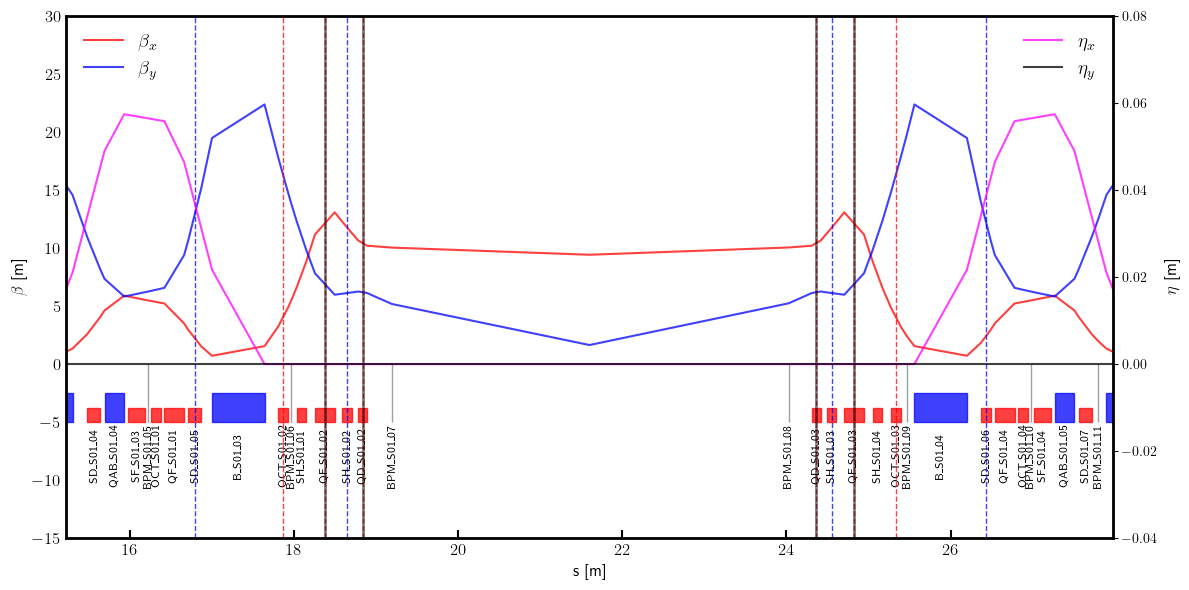

In [14]:
# Plot twiss parameters and local knobs

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles, labels = layout.profile_1d(scale=5, shift=-5.0, text=True,  delta=-8.0, fontsize=8, exclude=['Marker', 'Drift'])

fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(ring.locations().cpu().numpy(), bx.cpu().numpy(), fmt='-', color='red', alpha=0.75, label=r'$\beta_x$')
ax.errorbar(ring.locations().cpu().numpy(), by.cpu().numpy(), fmt='-', color='blue', alpha=0.75, label=r'$\beta_y$')

x_min = ring.locations()[ring.position('BPM_S01_05')] - 1.0
x_max = ring.locations()[ring.position('BPM_S01_10')] + 1.0

ax.set_xlim(x_min, x_max)
ax.set_ylim(-15.0, 30.0)

for rectangle in rectangles:
    ax.add_patch(Rectangle(**rectangle))
for label in labels:
    if x_min < label['x'] < x_max:
        ax.text(**label)

ax.set_ylabel(r'$\beta$ [m]', fontsize=12)
ax.set_xlabel(r's [m]', fontsize=12)
ax.legend(loc='upper left', frameon=False, fontsize=14, ncol=1)
ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
ax.tick_params(axis='y', length=0, width=0, labelsize=12)

ax = ax.twinx()
ax.set_ylabel(r'$\eta$ [m]', fontsize=12)
ax.errorbar(ring.locations().cpu().numpy(), etaqx.cpu().numpy(), fmt='-', color='magenta', alpha=0.75, label=r'$\eta_x$')
ax.errorbar(ring.locations().cpu().numpy(), etaqy.cpu().numpy(), fmt='-', color='black', alpha=0.75, label=r'$\eta_y$')
ax.legend(loc='upper right', frameon=False, fontsize=14, ncol=1)

ax.set_ylim(-0.04, 0.08)

for name in nkn:
    ax.axvline(ring.locations()[ring.position(name)] + ring[name].length/2, color='red', linestyle='--', linewidth=1.0, alpha=0.75)

for name in nks:
    ax.axvline(ring.locations()[ring.position(name)] + ring[name].length/2, color='blue', linestyle='--', linewidth=1.0, alpha=0.75)

ax.axvline(ring.locations()[ring.position('QF_S01_02')] + ring['QF_S01_02'].length/2, color='black', linewidth=2.0, alpha=0.5)
ax.axvline(ring.locations()[ring.position('QF_S01_03')] + ring['QF_S01_03'].length/2, color='black', linewidth=2.0, alpha=0.5)
ax.axvline(ring.locations()[ring.position('QD_S01_02')] + ring['QD_S01_02'].length/2, color='black', linewidth=2.0, alpha=0.5)
ax.axvline(ring.locations()[ring.position('QD_S01_03')] + ring['QD_S01_03'].length/2, color='black', linewidth=2.0, alpha=0.5)

plt.setp(ax.spines.values(), linewidth=2.0)

plt.tight_layout()
plt.show()

In [15]:
# QF02, QF03, QD02, QD03 are in local and global groups and are in a dispersive free region
# OCT02 and OCT03 are in a local group and are in a dispersive free region
# SH02 and SH03 are in dispersion free region and can be used for betatron coupling correction
# SD05, SH06 are in a non-zero disperson region and can be used for dispersion correction and betatron coupling

In [16]:
# With symmetry constraint one has 2 global knobs and 3+2 local knobs
# G-knobs: kf (1, ) is for QF_S*_0{2, 3}, kd (1, ) is for QD_S*_0{2, 3}
# L-knobs: kn (3, ) are for Q{F, D}_S??_0{2, 3} and OCT_S??_0{2, 3}, ks (2, ) are for SD_S??_0{5,6} and SH_S??_0{2,3}
# Note, all these relations can be expressed by a matrix

In [17]:
# Define parametric observables

Sn = torch.tensor([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0]], dtype=dtype)
Ss = torch.tensor([[+1.0, 0.0], [0.0, +1.0], [0.0, -1.0], [-1.0, 0.0]], dtype=dtype)

def knobs_split(knobs):
    kf, kd, kn, ks = torch.split(knobs, [1, 1, 3, 2])
    kn = Sn @ kn
    ks = Ss @ ks
    return kf.squeeze(), kd.squeeze(), kn, ks

def knobs_build(knobs):
    kf, kd, kn, ks = knobs_split(knobs)
    names = QF + QD
    values = torch.stack(len(QF)*[kf] + len(QD)*[kd])
    data = {name: value for name, value in zip(names, values)}
    for name, value in zip(nkn, kn):
        if name in data:
            data[name] = data[name] + value
    data = {**data, **{name: value for name, value in zip(nkn, kn) if name not in names}}
    nn = [name for name in data]
    kn = torch.stack([data[name] for name in data])
    return (nn, kn), (nks, ks)


def observable_tune(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    nux, nuy = tune(ring, [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), matched=True, limit=1)
    return torch.stack([nux, nuy])

    
def observable_twiss(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    _, bx, _, by = twiss(ring, 
                         [kn, ks],
                         ('kn', None, nn, None),
                         ('ks', None, ns, None),
                         matched=True, 
                         advance=True,
                         full=False, 
                         convert=True).T
    return torch.stack([bx, by]).T


def observable_dispersion(knobs):
    (nn, kn), (ns, ks) = knobs_build(knobs)
    orbit = torch.tensor(4*[0.0], dtype=dtype)
    etax, _, etay, _ = dispersion(ring, 
                                  orbit,
                                  [kn, ks],
                                  ('kn', None, nn, None),
                                  ('ks', None, ns, None))
    return torch.stack([etax, etay]).T

In [18]:
# Tune derivative

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)

print(torch.func.jacfwd(observable_tune)(knobs))

tensor([[ 5.8543,  2.0964,  0.0764,  0.4879,  0.1747,  0.0000,  0.0000],
        [-2.9918, -1.2602, -0.3117, -0.2493, -0.1050,  0.0000,  0.0000]],
       dtype=torch.float64)


In [19]:
# Beta function derivatives

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)
dbxdk, dbydk = torch.func.jacfwd(observable_twiss)(knobs).permute(1, -1, 0)

print(dbxdk.shape)
print(dbydk.shape)

torch.Size([7, 1512])
torch.Size([7, 1512])


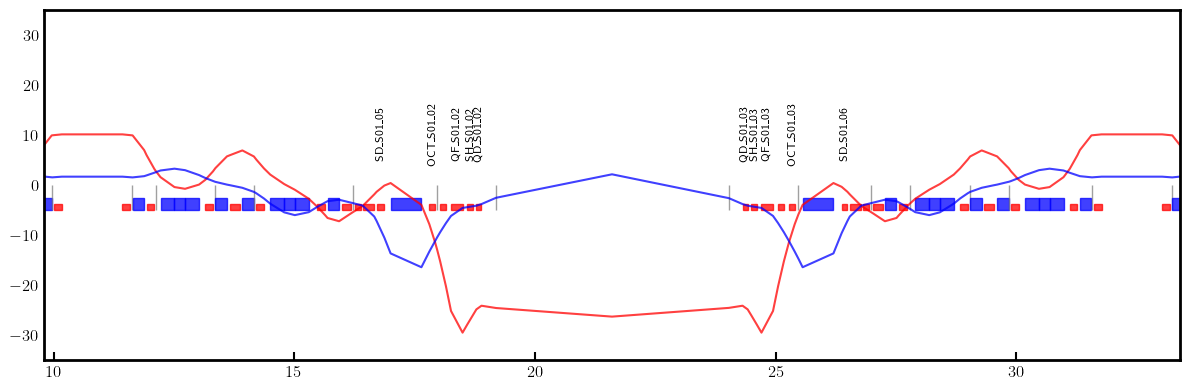

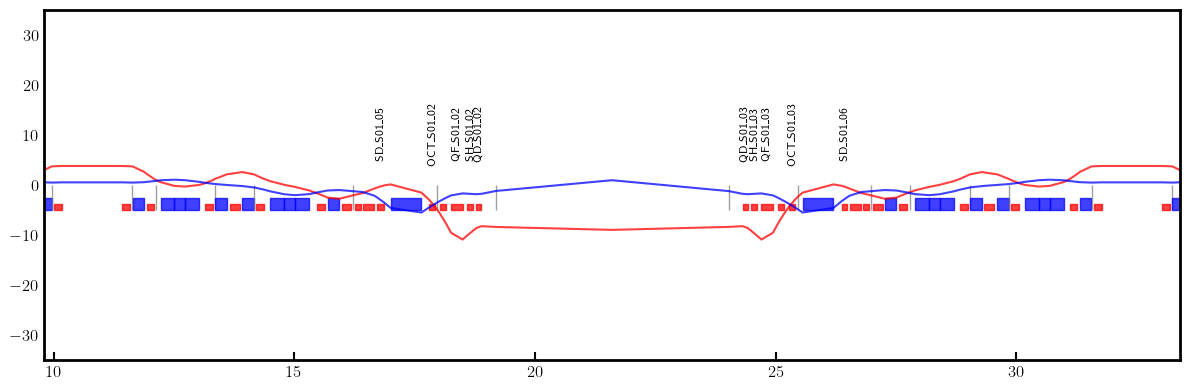

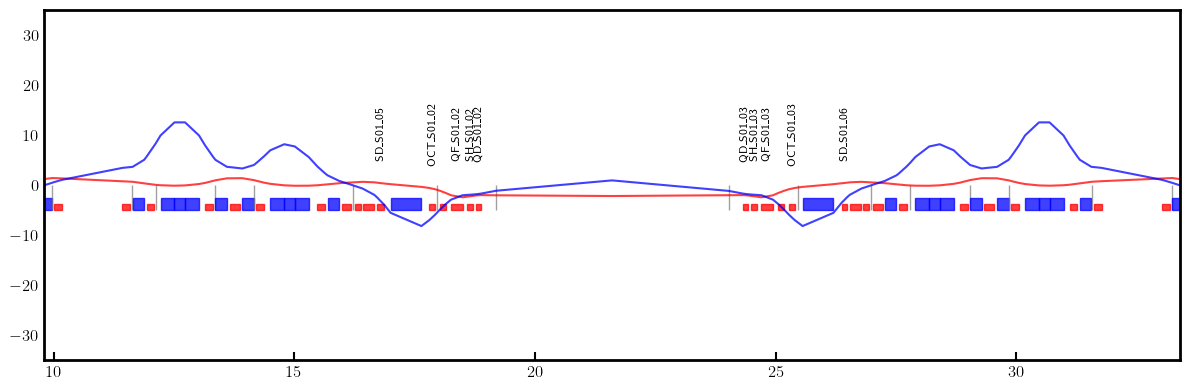

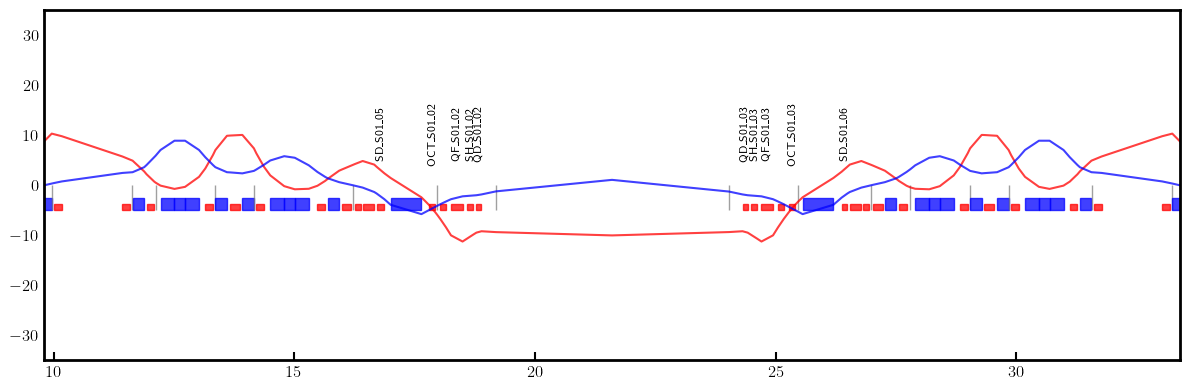

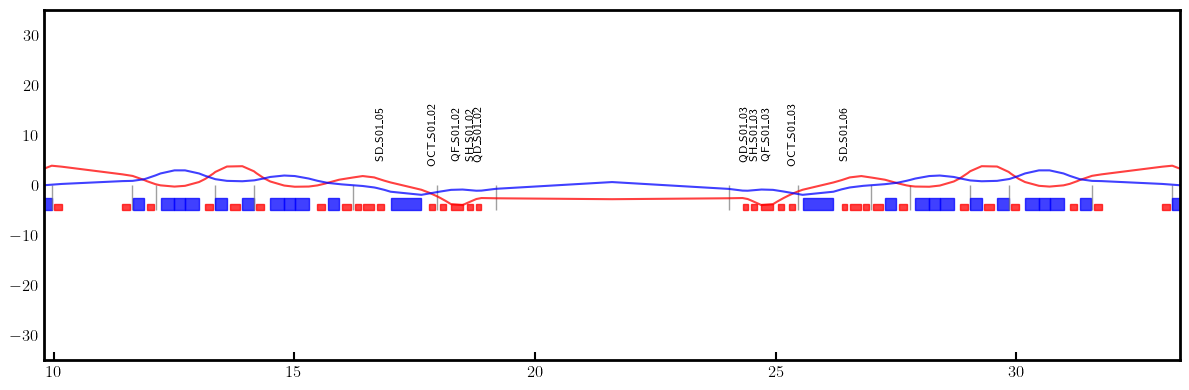

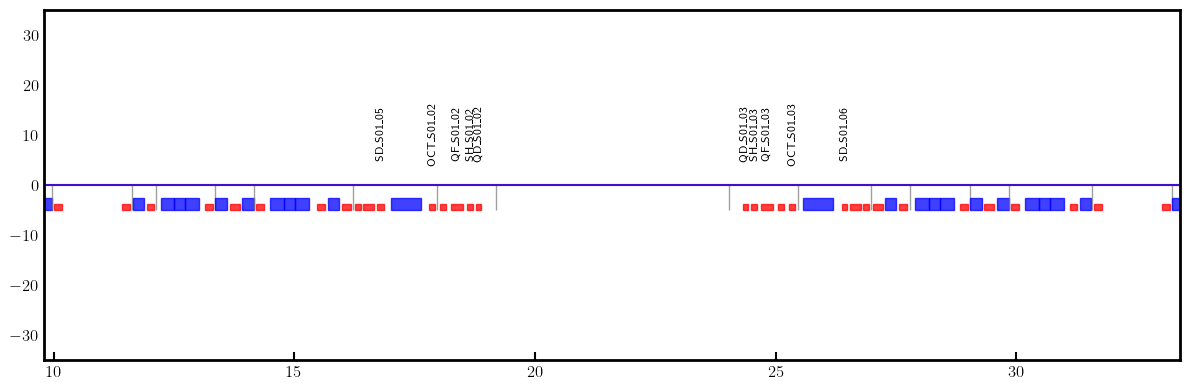

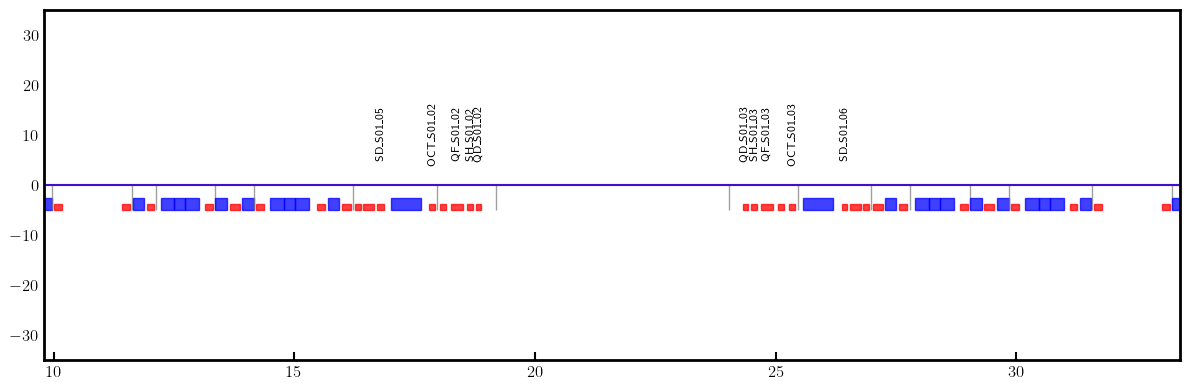

In [20]:
# Plot derivatives for each knob

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles, labels = layout.profile_1d(scale=5, shift=-5.0, text=True,  delta=10.0, fontsize=8, exclude=['Marker', 'Drift'])

for dbx, dby in zip(dbxdk, dbydk):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.errorbar(ring.locations().cpu().numpy(), dbx.cpu().numpy(), fmt='-', color='red', alpha=0.75)
    ax.errorbar(ring.locations().cpu().numpy(), dby.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
    x_min = 0.5*ring.length/12.0 - 1.0
    x_max = 1.5*ring.length/12.0 + 1.0
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(-35, +35)
    ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis='y', length=0, width=0, labelsize=12)
    for rectangle in rectangles:
        ax.add_patch(Rectangle(**rectangle))
    for label in labels:
        if x_min < label['x'] < x_max and label['s'] in QF + QD + nkn + nks:
            ax.text(**label)        
    plt.setp(ax.spines.values(), linewidth=2.0)
    plt.tight_layout()
    plt.show()

In [21]:
# Eta function derivatives

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)
detaxdk, detaydk = torch.func.jacfwd(observable_dispersion)(knobs).permute(1, -1, 0)

print(detaxdk.shape)
print(detaydk.shape)

torch.Size([7, 1512])
torch.Size([7, 1512])


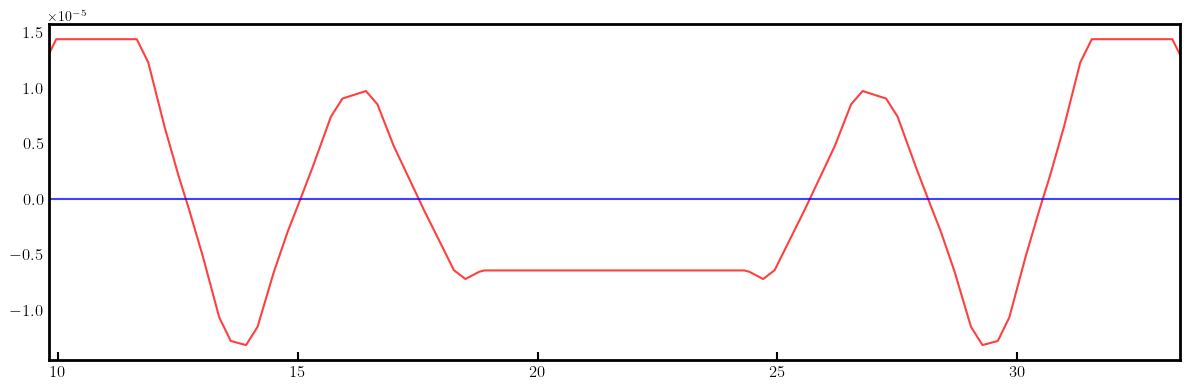

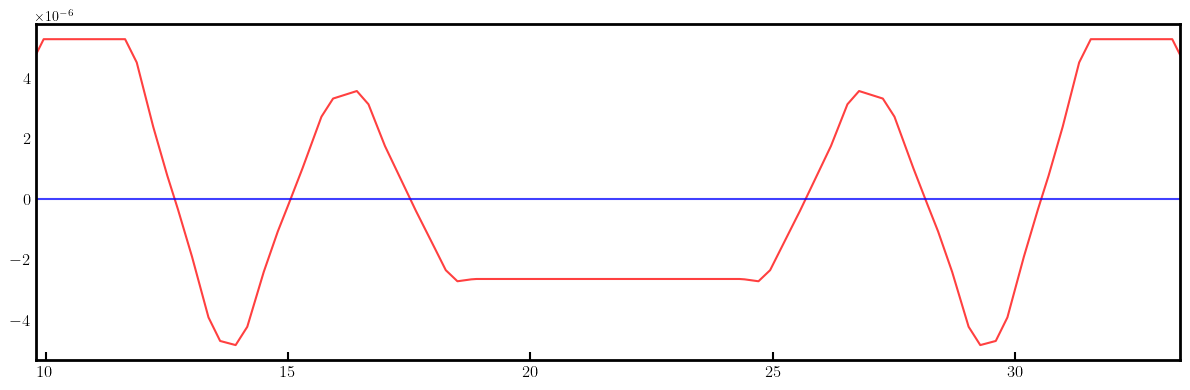

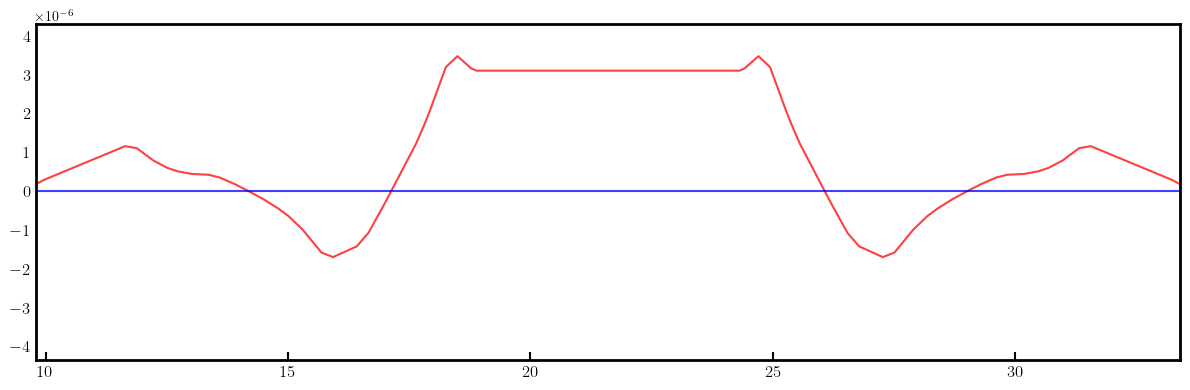

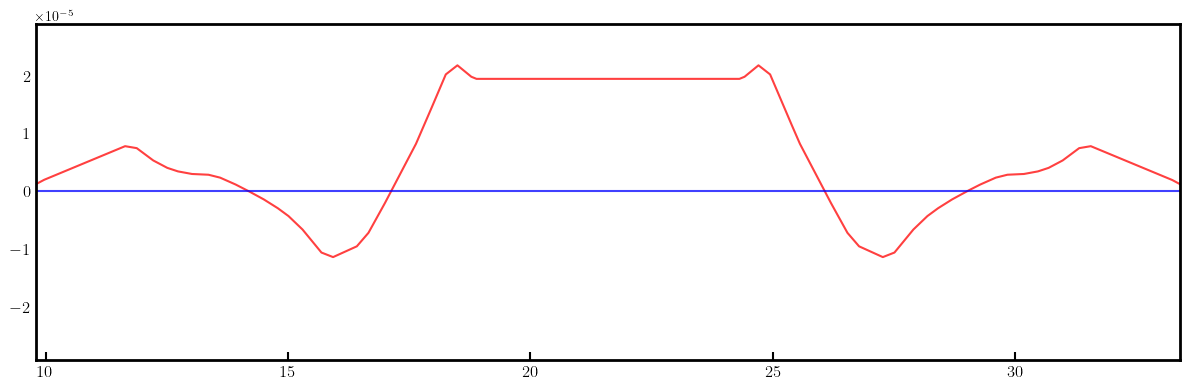

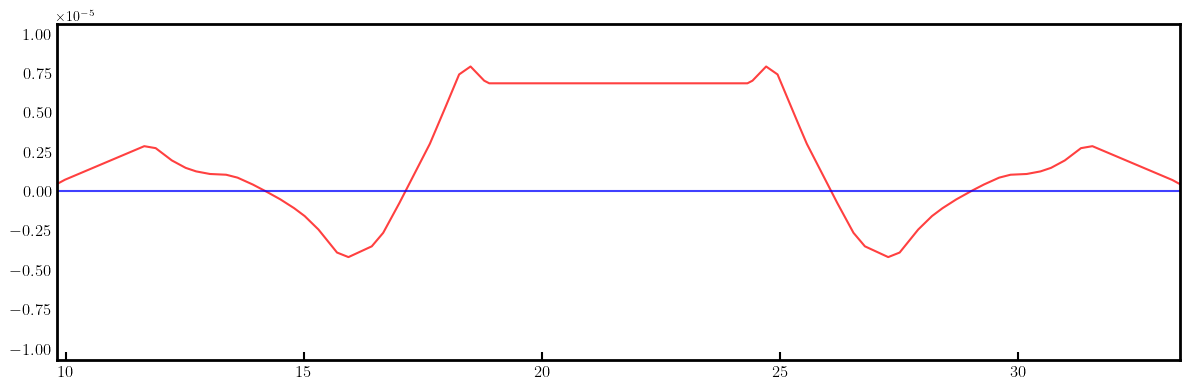

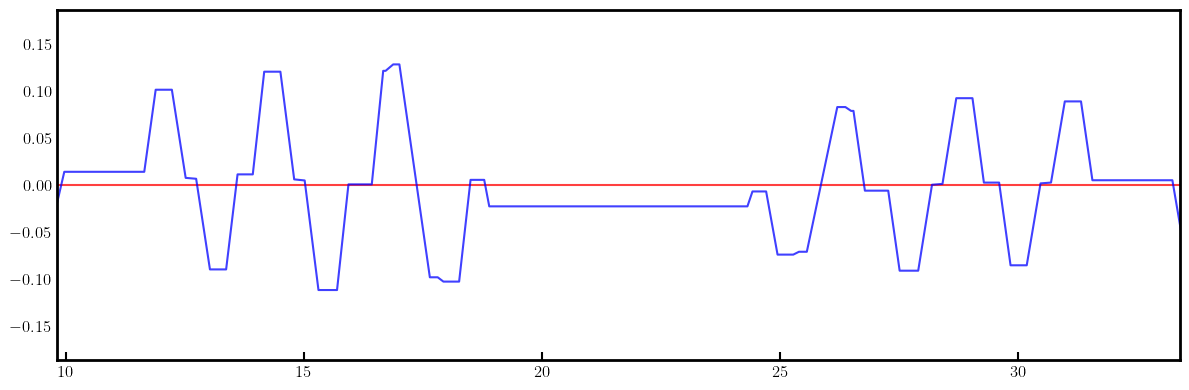

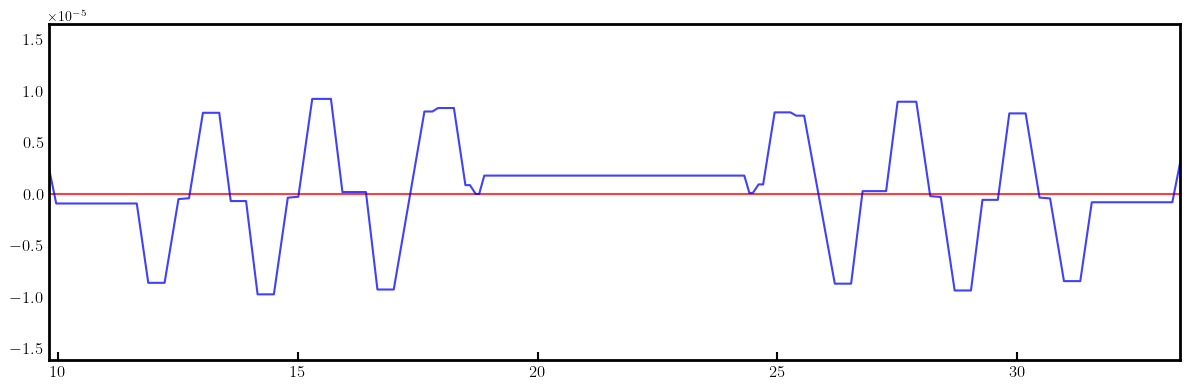

In [22]:
# Plot derivatives for each knob

layout = Layout(ring)
_, _, lengths, *_ = layout.slicing_table()
rectangles, labels = layout.profile_1d(scale=5, shift=-5.0, text=True,  delta=10.0, fontsize=8, exclude=['Marker', 'Drift'])

for detax, detay in zip(detaxdk, detaydk):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.errorbar(ring.locations().cpu().numpy(), detax.cpu().numpy(), fmt='-', color='red', alpha=0.75)
    ax.errorbar(ring.locations().cpu().numpy(), detay.cpu().numpy(), fmt='-', color='blue', alpha=0.75)
    x_min = 0.5*ring.length/12.0 - 1.0
    x_max = 1.5*ring.length/12.0 + 1.0
    ax.set_xlim(x_min, x_max)
    ax.tick_params(axis='x', length=6, width=1.5, direction='in', labelsize=12, bottom=True, top=False, labelbottom=True, labeltop=False)
    ax.tick_params(axis='y', length=0, width=0, labelsize=12)    
    plt.setp(ax.spines.values(), linewidth=2.0)
    plt.tight_layout()
    plt.show()

In [23]:
# Construct the linear relation matrix explicitly

nn = QF + QD
for name in nkn:
    if name not in nn:
        nn.append(name)

ns = nks

names = nn + ns
table = []
for name in names:
    local = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)
    if name in QF          : local[0] = +1.0
    if name in QD          : local[1] = +1.0
    if name == 'OCT_S01_02': local[2] = +1.0
    if name == 'QF_S01_02' : local[3] = +1.0
    if name == 'QD_S01_02' : local[4] = +1.0
    if name == 'QD_S01_03' : local[4] = +1.0
    if name == 'QF_S01_03' : local[3] = +1.0
    if name == 'OCT_S01_03': local[2] = +1.0
    if name == 'SD_S01_05' : local[5] = +1.0
    if name == 'SH_S01_02' : local[6] = +1.0
    if name == 'SH_S01_03' : local[6] = -1.0
    if name == 'SD_S01_06' : local[5] = -1.0
    table.append(local)

table = torch.stack(table)

print(table)

tensor([[ 1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 

In [24]:
# Test and compare tune derivatives

def observable_tune(knobs):
    kn, ks = torch.split(table @ knobs, [len(nn), len(ns)])
    nux, nuy = tune(ring, [kn, ks], ('kn', None, nn, None), ('ks', None, ns, None), matched=True, limit=1)
    return torch.stack([nux, nuy])

knobs = torch.tensor((1 + 1 + 3 + 2)*[0.0], dtype=dtype)

print(torch.func.jacfwd(observable_tune)(knobs))

tensor([[ 5.8543,  2.0964,  0.0764,  0.4879,  0.1747,  0.0000,  0.0000],
        [-2.9918, -1.2602, -0.3117, -0.2493, -0.1050,  0.0000,  0.0000]],
       dtype=torch.float64)
